In [3]:
import os
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision as tv
import tqdm
from scipy.optimize import Bounds, minimize
from torch import optim
from torch.autograd import Variable
from torch.functional import F
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision import datasets, transforms

# Week 14:  Intriguing Properties of Neural Networks
There are two types of adversarial models that we will create. First, we will reproduce some of the results of Szegedy via targeted misclassifications, and also test the cross-model susceptibility.  An optional second section explores the development of a different method for generating adversarial examples called the Fast Gradient Sign Method.

### Part 1: Targeted Examples

Now we will find inputs that will cause the network to mispredict in such a way that it outputs what we want it to.

In [4]:
Config = namedtuple(
    "Config",
    (
        "batch_size",
        "epochs",
        "lr",
        "lr_gamma",
        "input_size",
        "output_size",
        "w_decay",
        "r_weight",
        "device",
    )
)

device = "cuda"

config = Config(
    batch_size=64,
    epochs=25,
    # Learning rate
    lr=1e-4,
    # Learning rate decay factor
    lr_gamma=0.88,
    input_size=28*28,
    output_size=10,
    # L2 regularization strength
    w_decay=1e-4,
    # c from section 4.1 of the paper
    r_weight=0.15,
    device=device,
)

### Data

We'll use the full MNIST datasets for training and testing.

In [5]:
os.makedirs("./data", exist_ok=True)
# MNIST Datasets
train_ds = tv.datasets.MNIST(
    "./data",
    transform=tv.transforms.ToTensor(),
    train=True,
    download=True
)
test_ds = tv.datasets.MNIST(
    "./data",
    transform=tv.transforms.ToTensor(),
    train=False,
)
# MNIST Data Loaders
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=config.batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=4,
)
test_dl = torch.utils.data.DataLoader(
    test_ds,
    batch_size=config.batch_size,
    shuffle=True
)

### Helpers

These are some helper functions that you don't need to worry about

In [6]:
def train(model, opt, loss_func, loader, config, epoch):
    it = tqdm.tqdm(loader, ncols=80, desc=f"train: {epoch + 1}/{config.epochs}")
    for imgs, targets in it:
        model.train()
        opt.zero_grad()
        imgs = imgs.to(config.device).double()
        targets = targets.to(config.device)
        out = model(imgs)
        loss = loss_func(out, targets)
        loss.backward()
        opt.step()
        
        
def test(model, loader, config):
    correct = 0
    for imgs, targets in tqdm.tqdm(loader, ncols=80, desc="Test"):
        model.eval()
        imgs = imgs.to(config.device).double()
        targets = targets.to(config.device)
        with torch.no_grad():
            out = model(imgs)
            pred = logits_to_label(out)
            correct += (pred == targets).sum()
    N = len(loader.dataset)
    acc = float(correct) / N
    print(f"Test acc: {acc:.02%}")

    
def fetch_trained_model(model_class, train_loader, test_loader, load_from_file, path, config):
    """Either fetch a stored model from disk or train one from scratch"""
    model = model_class(config).double().to(config.device)
    if os.path.isfile(path) and load_from_file:
        model.load_state_dict(torch.load(path))
        test(model, test_loader, config)
    else:
        opt = torch.optim.Adam(model.parameters(), config.lr, weight_decay=config.w_decay)
        # Learning rate adjuster
        sched = torch.optim.lr_scheduler.StepLR(opt, 1, config.lr_gamma)
        criterion = nn.CrossEntropyLoss()

        for ep in range(config.epochs):
            train(model, opt, criterion, train_loader, config, ep)
            test(model, test_loader, config)
            sched.step()
        torch.save(model.state_dict(), path)
    model.eval()
    print(model)
    return model

### Model
We'll use one of the fully connected models from the paper.

In [7]:
def logits_to_label(logits):
    """
    Converts the logits or log-odds output of the networks
    to a class label.
    """
    return torch.softmax(logits, 1).argmax(1)


class FCNet100(nn.Module):
    """The FC100-100-10 network from the paper"""

    def __init__(self, config):
        super(FCNet100, self).__init__()
        self.config = config
        self.model = nn.Sequential(
            nn.Linear(config.input_size, 100),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(100, 100),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(100, config.output_size),
        )
        # Note that softmax is left out of the model on purpose.
    
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x).to(self.config.device)
        x = x.view(x.size(0), self.config.input_size)
        # Logits
        return self.model(x)

For convenience, a pre-trained set of weights are included in this repository at './data/model_1.pt'.
The code below will load them for you. Pass `False` to the `load` argument to train a fresh version
of the model. Note that `double()` has been called on the model so that all of the weights are 64-bit floats
and the model is expecting 64-bit float inputs. The model will also produce 64-bit floats as outputs.
This last part is why `double()` is called and is important later.

In [8]:
# Load our first model from disk or train a fresh one
model = fetch_trained_model(
    FCNet100,
    train_dl,
    test_dl,
    True,
    "./data/model_1.pt",
    config
)

Test: 100%|██████████████████████████████████| 157/157 [00:01<00:00, 133.89it/s]

Test acc: 94.44%
FCNet100(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


## Finding Adversarial Examples

The two functions below are used to find targeted examples. Together these make up the algorithm
descriibed in Section 4.1 of the paper:

$$\textrm{minimize} \quad c \left\lvert r \right\rvert + \textrm{loss}_f(x + r, l)$$
with $$x + r \in [0, 1]^m$$

In [21]:
class TorchGradientCalculator:
    def __init__(self,x_initial,net,c,target,device):
        self.net = net
        self.target = target
        self.device = device
        self.c = c
        self.x_initial = torch.tensor(x_initial.reshape(1, 28, 28)).to(device)
        self.cost = None
        self.g = None
        
    # find the cross entropy for class_penalty
    def _F(self,x_plus_r):
        x_plus_r_tensor = torch.tensor(x_plus_r.reshape(1, 28, 28),requires_grad=True).to(device)
        logits = self.net(x_plus_r_tensor)
        class_penalty = nn.functional.cross_entropy(logits, self.target)
        size_penalty = torch.norm(self.c * torch.abs(x_plus_r_tensor - self.x_initial))
        self.cost = size_penalty + class_penalty
        self.g = torch.autograd.grad(self.cost,x_plus_r_tensor)[0]
        return self.cost.detach().cpu().numpy()
    
    def _G(self,x_plus_r):
        return self.g.detach().cpu().numpy().ravel()

In [10]:
def find_adversarial_example(
    net, x, target, config, max_iterations=45_000, max_penalty_function_calls=45_000
):
    """This is the optimization problem described in Section 4.1"""
    # The c weight for the L1 norm of r
    c = config.r_weight
    # Box constraint: [0, 1]^m
    box_constraint = Bounds(np.zeros_like(x.ravel()), np.ones_like(x.ravel()))
    # Target label as tensor
    target = torch.tensor([target]).to(config.device, dtype=torch.int64)
    # Args that will be passed to the penalty function in addition to the (x + r) array.
    args = (x.flatten(), net, c, target, device)
    #
    # TODO: What should the initial guess for x+r be?
    #
    x_plus_r_initial = x + 0.001
    
    tgc = TorchGradientCalculator(*args)
    
    # minimize will be calling the penalty function, and in turn the model, a LOT.
    # We use torch.no_grad() to make sure that we don't have the overhead of
    # torch's autograd during those calls.

    # We'll treat scipy's minimize as a black box and simply use it as a means to an
    # end. Below, we have used the recommended settings for "L-BFGS-B" from the
    # scipy docs.
    res = minimize(
            # Our penalty function from above
            tgc._F,
            # Flatten it since minimize only works on a 1D array
            x_plus_r_initial.flatten(),
            method='L-BFGS-B',
            jac=tgc._G,
            bounds=box_constraint,
            tol=None,
            callback=None,
            options={
                'disp': None,
                'maxcor': 10,
                'ftol': 2.220446049250313e-09,
                'gtol': 1e-05,
                # This is the step size used by the numerical optimizer
                'eps': 1e-9,
                # The maximum number of times the penalty func can be called by minimize
                'maxfun': max_penalty_function_calls,
                # The maximum number of steps taken by minimize
                'maxiter': max_iterations,
                'iprint': -1,
                'maxls': 15,
            }
        )
    # Reshape back into an image
    xr = torch.tensor(res.x.reshape(x.shape))
    return xr

### Starting Images
Now we will select some images from the test dataset, which the model hasn't seen, to turn into adversarial
examples.

[[7 2 1 0]
 [4 1 4 9]
 [9 0 6 9]
 [0 1 5 9]]


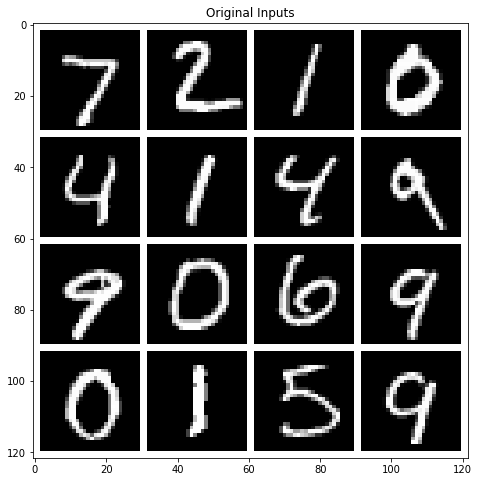

In [11]:
# Select N images that the model correctly classifies already
N = 16
adv_target = 8
x_imgs = []
x_labels = []
for x, label in test_ds:
    if label == adv_target:
        continue
    x = x.to(config.device).double()
    # Make sure that the model correctly classifies this x
    if (logits_to_label(model(x)) == label).item():
        x_imgs.append(x.cpu())
        x_labels.append(label)
    if len(x_imgs) >= N:
        break

x_labels = np.array(x_labels).reshape(4, 4)
grid = tv.utils.make_grid(x_imgs, nrow=4, pad_value=1)
plt.figure(figsize=(8, 8))
plt.title("Original Inputs")
plt.imshow(np.transpose(grid, (1, 2, 0)))
print(x_labels)

## Creating Adversaries
This code will call the functions above to create adverserial examples. Unfortunately, it
runs pretty slowly so it can take some time to find them. You can try adjusting
the `max_iterations` and `max_penalty_function_calls` parameters of
`find_adversarial_example()` to speed things up. Note that if you lower them too far you
will produce poor examples that don't fool the network or that have large distortions. You can
also adjust c to weight the size of r more or less.

In [22]:
xr_imgs = []
xr_labels = []
for x in tqdm.tqdm(x_imgs, ncols=80):
    xr = find_adversarial_example(model, x.numpy(), adv_target, config)
    xr_imgs.append(xr)
    new_label = logits_to_label(model(xr.to(config.device))).item()
    xr_labels.append(new_label)
xr_labels = np.array(xr_labels).reshape(4, 4)

100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.34it/s]


## Adversarial Results

If everything is working properly, all of the new images should be classified as the target class.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


New Labels:
[[8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]]


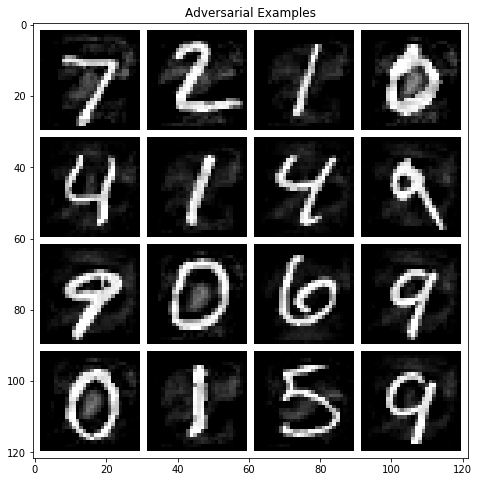

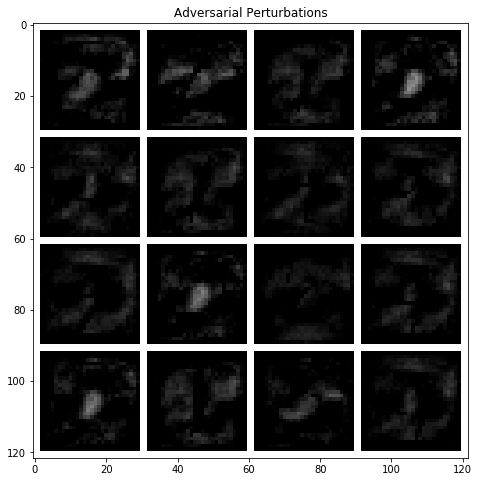

In [23]:
grid = tv.utils.make_grid(xr_imgs, nrow=4, pad_value=1)
plt.figure(figsize=(8, 8))
plt.title("Adversarial Examples")
plt.imshow(np.transpose(grid, (1, 2, 0)))
print(f"New Labels:\n{xr_labels}")

# Calculate r = (x + r) - x and display them
r_imgs = [xr - x for xr, x in zip(xr_imgs, x_imgs)]
grid = tv.utils.make_grid(r_imgs, nrow=4, pad_value=1)
plt.figure(figsize=(8, 8))
plt.title("Adversarial Perturbations")
plt.imshow(np.transpose(grid, (1, 2, 0)))

## Cross Network Attack
Now we'll try using the examples created using one network to attack another.
Below is a model similar to the one used above that has pre-trained weights.

In [30]:
class FCNet200(nn.Module):
    def __init__(self, config):
        super(FCNet200, self).__init__()
        self.config = config
        self.model = nn.Sequential(
            nn.Linear(config.input_size, 200),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(200, 200),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(200, config.output_size),
        )
    
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x).to(self.config.device)
        x = x.view(x.size(0), self.config.input_size)
        # Logits
        return self.model(x)

This loads the pre-trained weights for the model above. If you change the `True` to `False`
it will train the model from scratch.

In [31]:
model2 = fetch_trained_model(
    FCNet200,
    train_dl,
    test_dl,
    True,
    "./data/model_2.pt",
    config
)

Test: 100%|██████████████████████████████████| 157/157 [00:01<00:00, 101.39it/s]

Test acc: 95.98%
FCNet200(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Linear(in_features=200, out_features=10, bias=True)
  )
)


In [32]:
cross_model_labels = []
for xr in xr_imgs:
    label = logits_to_label(model2(xr.unsqueeze(0).to(config.device))).item()
    cross_model_labels.append(label)
cross_model_labels = np.array(cross_model_labels).reshape(4, 4)

print(f"Cross Model Adverserial Predictions:\n{cross_model_labels}")
print(f"Attack Success: {(cross_model_labels == xr_labels).sum() / N:.2%}")

Cross Model Adverserial Predictions:
[[8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]]
Attack Success: 100.00%


**Bonus: Try experimenting with the second model's architecture to see if it affects the attack
success rate.**

### Part 2: Fast Gradient Sign Method (Optional)

This section implements the [Fast Gradient Sign Method](https://arxiv.org/abs/1412.6572), which is a fast alternative method for finding adversarial examples.  It is untargeted, in the sense that unlike the section above, you don't get to choose what your image gets classified as.

The following cell is group of helper functions.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_dataset(torchvision_dataset):
    save_dir = "./data"
    transform_list = [transforms.ToTensor()]
    transform = transforms.Compose(transform_list)
    kwargs = {
        "download": True,
        "transform": transform,
    }
    train = torchvision_dataset(save_dir, train=True, **kwargs)
    test = torchvision_dataset(save_dir, train=False, **kwargs)
    return train, test


def resize_dataset(dataset, dataset_len=None):
    if dataset_len is None:
        return dataset
    assert 0 <= dataset_len <= len(dataset)
    ignored_len = len(dataset) - dataset_len
    sizes = (dataset_len, ignored_len)
    dataset, ignored = random_split(dataset, sizes)
    return dataset


def make_batches(train, test, batch_size=100):
    assert 1 <= batch_size <= len(test)
    kwargs = {
        "batch_size": batch_size,
        "shuffle": True,
    }
    train_loader = DataLoader(train, **kwargs)
    test_loader = DataLoader(test, **kwargs)
    return train_loader, test_loader
    
def train_model(model, device, train_loader, optimizer, criterion, num_epochs=1):
    for epoch in range(num_epochs):
        print("Training Epoch", epoch)
        for i, (images, targets) in enumerate(train_loader):
            images = images.to(device)
            targets = targets.to(device)

            # Forward
            outputs = model(images)

            # Backward
            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

def test_model(model, device, test_loader):
    correct = 0
    total = 0
    for i, (images, targets) in enumerate(test_loader):
        images = images.to(device)
        targets = targets.to(device)

        # Forward
        outputs = model(images)

        # Prediction
        predicted = torch.argmax(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

### Model Definition
This is our convolutional network that we use to train both our adversarial and non-adversarial models.

In [ ]:
class Conv_Net(nn.Module):
    def __init__(self, in_height, in_width, num_targets):
        super().__init__()
        # Convolutional parameters
        kernel_size = 4
        stride = 1

        # Pool layer and its parameters
        pool_kernel_size = 2
        pool_stride = pool_kernel_size # When these values are the same it reduces the image by half
        self.pool = nn.MaxPool2d(pool_kernel_size, pool_stride)

        in_channels_2 = 1
        out_channels_2 = 10
        self.conv2 = nn.Conv2d(
            in_channels_2,
            out_channels_2, 
            kernel_size=kernel_size, 
            stride=stride, 
        )
        self.bn2 = nn.BatchNorm2d(out_channels_2)

        self.conv2_height = height - kernel_size + 1
        self.conv2_width = width - kernel_size + 1
        self.conv2_size = self.conv2_height * self.conv2_width * out_channels_2

        self.pool1_height = int(self.conv2_height / pool_kernel_size)
        self.pool1_width = int(self.conv2_height / pool_kernel_size)
        self.pool1_size = self.pool1_height * self.pool1_width * out_channels_2

        out_channels_3 = 10
        self.conv3 = nn.Conv2d(
            out_channels_2, 
            out_channels_3, 
            kernel_size=kernel_size, 
            stride=stride, 
        )
        self.bn3 = nn.BatchNorm2d(out_channels_3)

        self.conv3_height = self.pool1_height - kernel_size + 1
        self.conv3_width = self.pool1_width - kernel_size + 1
        self.conv3_size = self.conv3_height * self.conv3_width * out_channels_3

        self.pool2_height = int(self.conv3_height / pool_kernel_size)
        self.pool2_width = int(self.conv3_height / pool_kernel_size)
        self.pool2_size = self.pool2_height * self.pool2_width * out_channels_2

        in_features_4 = self.pool2_size
        out_features_4 = int(in_features_4 / 2)
        self.fc1 = nn.Linear(in_features_4, out_features_4)
        self.bn4 = nn.BatchNorm1d(out_features_4)

        out_features_5 = int(out_features_4 / 2)
        self.fc2 = nn.Linear(out_features_4, out_features_5)
        self.bn5 = nn.BatchNorm1d(out_features_5)

        self.fc3 = nn.Linear(out_features_5, num_targets)

    def forward(self, x):
        # First convolution and pooling
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.bn2(x)

        # Second convolution and pooling
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.bn3(x)

        # Flattening convolutional layer for fully connected layer
        batch_size = -1
        x = x.view(batch_size, self.pool2_size) # This value was calculated in __init__

        # First fcl
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn4(x)

        # Second fcl
        x = self.fc2(x)
        x = F.relu(x)
        x = self.bn5(x)
       
        # Output fcl
        x = self.fc3(x)   
        x = F.log_softmax(x, dim=1)
        return x

### Non-adversarial Model

In [ ]:
# Load data
torchvision_dataset = datasets.MNIST
train, test = load_dataset(torchvision_dataset)

# Find dimensions
height, width = train.data[0].shape
num_targets = len(set(train.targets.numpy()))

# Setting the size to "None" will use all instances
train_len, test_len = 8000, 2000
train = resize_dataset(train, train_len)
test = resize_dataset(test, test_len)

# Batch
batch_size = 100
train_loader, test_loader = make_batches(train, test, batch_size)

# Make model
good_model = Conv_Net(height, width, num_targets).to(device)

# Optimizer
learning_rate = 0.001
optimizer = optim.Adam(good_model.parameters(), lr = learning_rate)

# Criterion
criterion = nn.CrossEntropyLoss()

# Train
num_epochs = 10
train_model(good_model, device, train_loader, optimizer, criterion, num_epochs)

# Test
accuracy = test_model(good_model, device, test_loader)
print(f"Original Accuracy: {accuracy} %")

### Adversarial parameters

In [ ]:
learning_rate = 0.001
# This is the length of the epsilon_list you are going to create. If your list is longer or shorter you must reflect that change in this variable.
num_epsilons = 5 

# Make a list of epsilon values for the attack
epsilon_list = [i / (num_epsilons * 2) for i in range(num_epsilons)]

# This is storage for samples from our adversarial model.
examples = {
    epsilon: {
        "original_images": [],
        "adversarial_images": [],
        "original_predictions": [],
        "adversarial_predictions": []
    }
    for epsilon in epsilon_list
}

Q: Below you will set the clamp min and max values on the line "torch.clamp(perturbated_images, clamp_min, clamp_max)". Why do we need to clamp and what would the effect of using a value outside the range be?

A:
    
Q: This is very subtle. Why are we adding our perturbations instead of subtracting them? The goal should be to go in the opposite direction of the gradient. How is addition moving us uphill?

A:

### Adversarial Model

In [ ]:
for epsilon in epsilon_list:
    print(f"Epsilon: {epsilon}")
    
    # Train Attack model
    attack_model = Conv_Net(height, width, num_targets).to(device)

    optimizer = optim.Adam(attack_model.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_model(attack_model, device, train_loader, optimizer, criterion, num_epochs)
    pre_attack_accuracy = test_model(attack_model, device, test_loader)
    print(f"Pre-attack Accuracy: {pre_attack_accuracy} %")

    correct = 0
    total = 0
    sample = True 
    
    for i, (images, targets) in enumerate(test_loader):
        images = images.to(device)
        # Enable finding gradient w.r.t the inputs.
        images.requires_grad = True 
        targets = targets.to(device)

        # Forward
        outputs = attack_model(images)
        predicted = torch.argmax(outputs, 1)

        # Backward
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()

        image_grad = images.grad 

        grad_sign = image_grad.sign()
        perturbation = ???
        perturbed_images = ???
        clamp_min = ???
        clamp_max = ??? # TODO
        perturbed_images = torch.clamp(perturbed_images, clamp_min, clamp_max)

        attack_output = attack_model(perturbed_images)
        attack_predicted = torch.argmax(attack_output, 1)
        
        total += targets.size(0)
        correct += (attack_predicted == targets).sum().item()
        
        if sample:
            sample = False
            
            with torch.no_grad():
                examples[epsilon]["original_images"] = images.cpu().numpy()[:num_epsilons]
                examples[epsilon]["adversarial_images"] = perturbed_images.cpu().numpy()[:num_epsilons]
                examples[epsilon]["original_predictions"] = predicted.cpu().numpy()[:num_epsilons]
                examples[epsilon]["adversarial_predictions"] = attack_predicted.cpu().numpy()[:num_epsilons]
            
        
    post_attack_accuracy = correct / total * 100
    print(f"Post-attack Accuracy: {post_attack_accuracy} %")
    print()

Q: If you were a real attacker that relied on misclassification, how would you deal with the cases where the class was retained?

A:

Q: Go back and look at where we set grad_sign. If we had multiplied the gradient instead of the gradient sign by the epsilon value our performance would not be as high. Why?

A:

Q: Our purturbations depended on the gradient of the image. Why is the gradient necessary as opposed to some non-gradient dependent function the input image?

A:

Q: You can misclassify an image by just mutating it. What is the point of this model? 

A:

### Plot sample of adversarial images

In [ ]:
plot_dim = 10, 12
plt.figure(figsize=plot_dim)

plot_index = 1
for row in range(num_epsilons):
    for column in range(num_epsilons):
        plt.subplot(num_epsilons, num_epsilons, plot_index)

        plt.xticks([], [])
        plt.yticks([], [])

        epsilon = epsilon_list[row]
        if column == 0:
            plt.ylabel("Eps: {}".format(epsilon), fontsize=14)

        adversarial_image = examples[epsilon]["adversarial_images"][column].squeeze()
        original_prediction = examples[epsilon]["original_predictions"][column].item()
        adversarial_prediction = examples[epsilon]["adversarial_predictions"][column].item()

        plt.title("{} -> {}".format(original_prediction, adversarial_prediction))
        plt.imshow(adversarial_image, cmap="gray")

        plot_index += 1
plt.tight_layout()
plt.show()

### Part 2: Bonus
Plot just the purturbations. You can modify the code from the cell above but put the new plotting code in this cell below so that both copies are retained.